In [2]:
import scipy.io
import scipy.stats as stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from matplotlib.patches import Ellipse
import skimage.feature
import time
import IPython.display as display

%matplotlib inline  

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

data = scipy.io.loadmat('data/kfdata.mat')

In [3]:
def plot_kalman(observed_x, observed_y, mus, true_x=None, true_y=None, sigmas=None):
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')
    mus = np.array( mus )
    
    if not isinstance(true_x, (np.ndarray, np.generic)): 
        pass
    else:
        c1, = ax.plot(true_x, true_y, color="blue", label="True Position")
    c2 = ax.scatter(observed_x, observed_y, color="blue", label="Observed Data")
    c3, = ax.plot(mus[:,0], mus[:,1], color="green", label="Estimated Position")
    
    if not isinstance(true_x, (np.ndarray, np.generic)): 
        ax.legend(handles=[c2, c3], loc=0)
    else:
        ax.legend(handles=[c1, c2, c3], loc=0)

    if sigmas:
        for x in xrange(len(sigmas)):
            ells = Ellipse(xy=np.array( [ mus[x][0], mus[x][1] ] ) , height=sigmas[x][0], width=sigmas[x][1], fill=False, color='red')
            ax.add_artist(ells)
    
    plt.show()
    
def calculateKalmanGain(St):
    model_uncertainty = A * St * A.T + Q
    return model_uncertainty *  C.T * np.linalg.inv( C * model_uncertainty * C.T + R )

def calculateNewMu(mu, Kt_1, z):
    return A * mu + Kt_1 * (z - C * A * mu)

def calculateFutureMu(mu):
    return A * mu

def calculateSigmaT(Kt, St):
    return (I - Kt * C) * (A * St * A.T + Q)

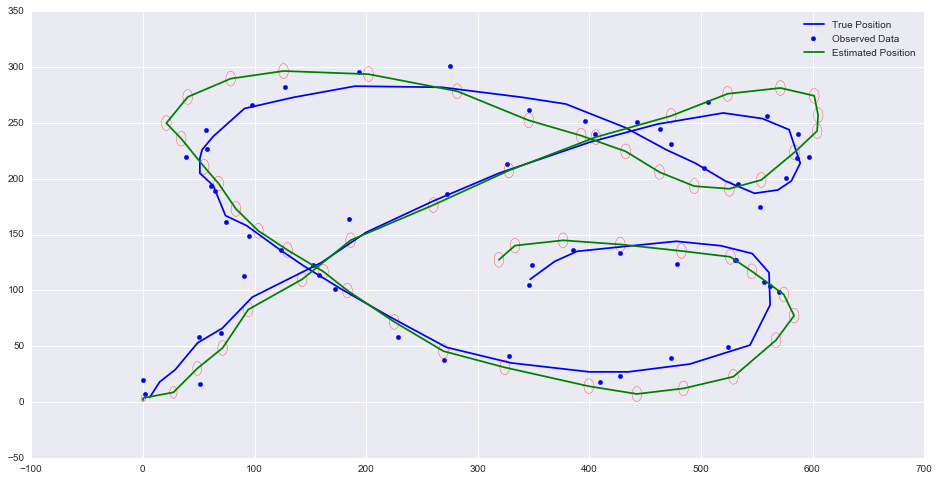

In [4]:
true_xvals = data['true_data'][:,0]
true_yvals = data['true_data'][:,1]

observed_x = data['data'][:,0]
observed_y = data['data'][:,1]


# our dynamics are described by random accelerations
A = np.matrix([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.matrix([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0]])
 

# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5

Q = np.matrix(Q)
 
# our observation noise
R = 20 * np.eye( 2 )

np.matrix(R)
 
# initial state
mu = np.zeros(( 6, 1 ))

np.matrix(mu)

St = np.eye( 6 )

I = np.matrix( St )

np.matrix(St)

mus = []
sigmas = []

Kt = 0

for i in xrange(len(observed_x)):
    z = [ [observed_x[i]], [observed_y[i]]]
    Kt = calculateKalmanGain(St)
    mu = calculateNewMu(mu, Kt, z)
    mus.append( [ float(mu[0][0]), float(mu[3][0]) ] ) #We care about the observed X and Y positions
    St = calculateSigmaT(Kt, St)
    sigmas.append( [ float(St[0,0]), float(St[3,3]) ] ) #Pull out the sigmas coorelating to positions
    
plot_kalman(true_x=true_xvals, true_y=true_yvals, observed_x=observed_x, observed_y=observed_y, mus=mus, sigmas=sigmas)


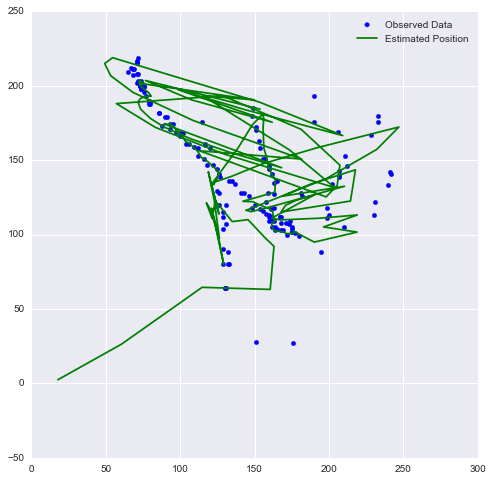

In [5]:
#####
#
# I ended up choosing the original parameters for my final tweaking, because it looked the best out of all of my tests
# where I didn't make extremely drastic changes. However, below this example I use parameters for a kalman filter from
# CS470, and as you can see from the graph, the predicted outputs follow the observed outputs VERY closely. I'm not
# sure if this is good or bad, but it's one test I did that included a drastic change and thought it was interesting.
#
#####



# our dynamics are described by random accelerations
A = np.matrix([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.matrix([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0]])
 

# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5

Q = np.matrix(Q)
 
# our observation noise
R = 20 * np.eye( 2 )

np.matrix(R)
 
# initial state
mu = np.zeros(( 6, 1 ))

np.matrix(mu)

St = np.eye( 6 )

I = np.matrix( St )

np.matrix(St)

mus = []
sigmas = []

Kt = 0


tmp = scipy.io.loadmat('data/ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
 
data = np.asarray( data )

for i in xrange(len(data)):
    z = [ [data[i][0]], [data[i][1]] ]
    Kt = calculateKalmanGain(St)
    mu = calculateNewMu(mu, Kt, z)
    mus.append( [ float(mu[0][0]), float(mu[3][0]) ] ) #We care about the observed X and Y positions
    St = calculateSigmaT(Kt, St)
    sigmas.append( [ float(St[0,0]), float(St[3,3]) ] ) #Pull out the sigmas coorelating to positions

plot_kalman(data[:,0], data[:,1], mus)


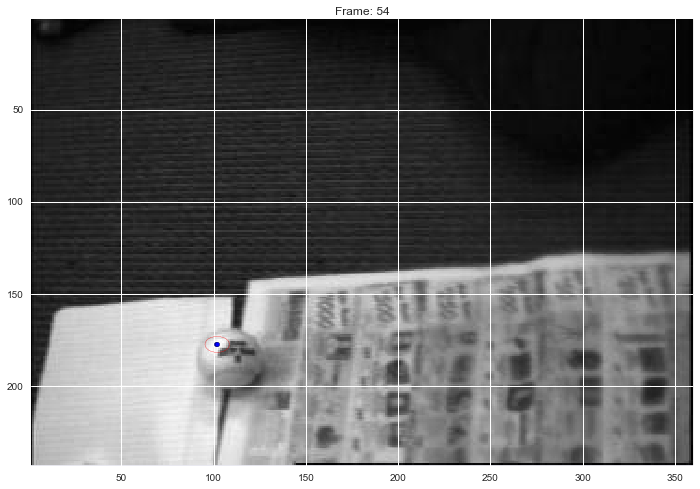

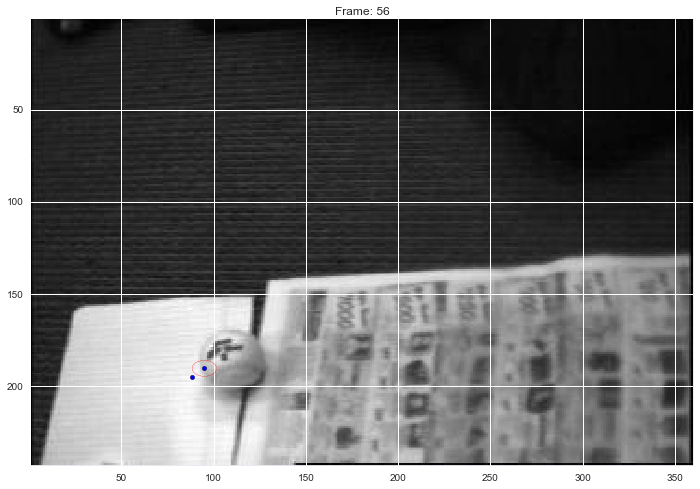

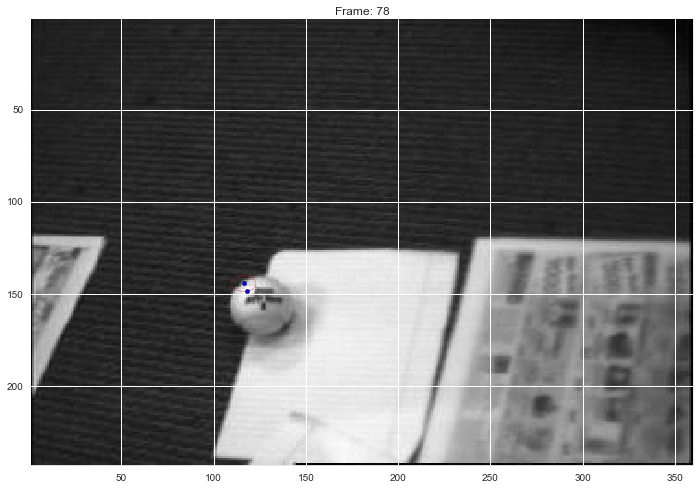

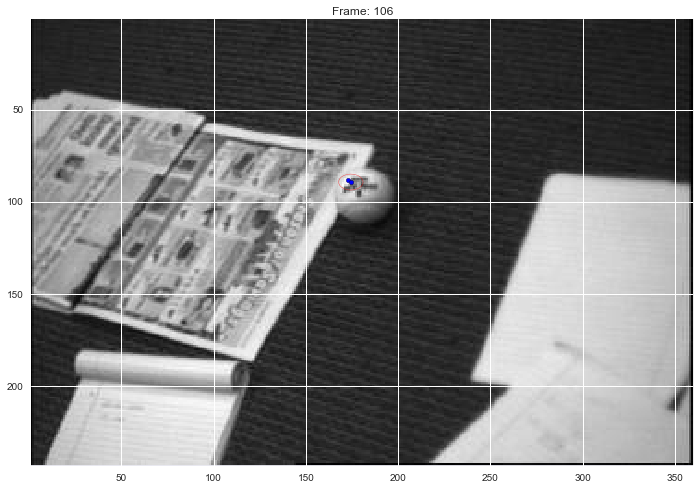

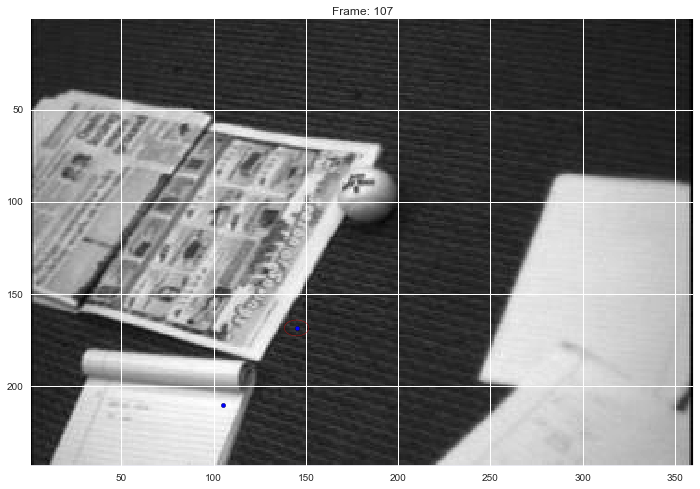

In [6]:
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    fig = plt.figure(1)
    ax = fig.add_subplot(111, aspect='equal')
    #fig.clf()
    ax.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    ax.scatter( data[t][1], data[t][0] )
    ax.scatter( mus[t][1], mus[t][0] )
 
    ells = Ellipse(xy=np.array( [ mus[t][1], mus[t][0] ] ) , height=sigmas[t][1], width=sigmas[t][0], fill=False, color='red')
    ax.add_artist(ells)
    ax.plot( sigmas[t][1] + mus[t][1], sigmas[t][0] + mus[t][0] )
    ax.set_xlim([1, 360])
    ax.set_ylim([243,1])
 
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #fig.clf()
    #time.sleep(0.3)
    
    if t in [54, 56, 78, 106, 107]:
        #display.clear_output(wait=True)
        plt.title("Frame: %d" % t)
        display.display(plt.gcf())
    fig.clf()

    #time.sleep(0.3)

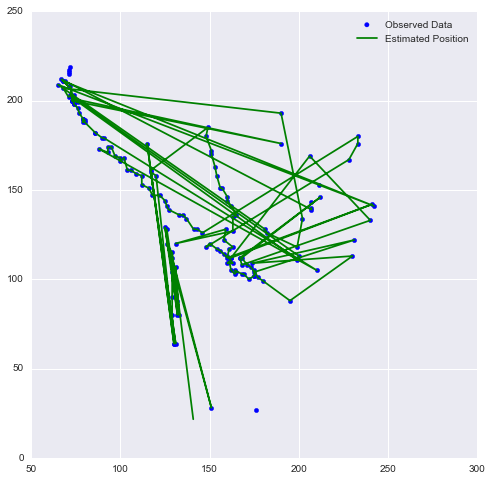

In [7]:
#Here is the Drastic Kalman Change from the original parameters. This was the Kalman Filter parameters used in our CS470 class. 

dt = 0.01
c = 0

A = np.matrix([
    [1, dt, (dt*dt)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, -c, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt*dt)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, -c, 1]
    ])
 
# our observations are only the position components
C = np.matrix([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0]])
 

# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5

Q = np.matrix([
    [0.1, 0, 0, 0, 0, 0],
    [0, 0.1, 0, 0, 0, 0],
    [0, 0, 100, 0, 0, 0],
    [0, 0, 0, 0.1, 0, 0],
    [0, 0, 0, 0, 0.1, 0],
    [0, 0, 0, 0, 0, 100]
    ])
 
# our observation noise
R = 25 * np.eye( 2 )

np.matrix(R)
 
# initial state
mu = np.zeros(( 6, 1 ))

np.matrix(mu)

St = np.matrix([
    [100, 0, 0, 0, 0, 0],
    [0, 0.1, 0, 0, 0, 0],
    [0, 0, 0.1, 0, 0, 0],
    [0, 0, 0, 100, 0, 0],
    [0, 0, 0, 0, 0.1, 0],
    [0, 0, 0, 0, 0, 0.1]
    ])

I = np.matrix( St )

np.matrix(St)

mus = []
sigmas = []

Kt = 0


tmp = scipy.io.loadmat('data/ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
 
data = np.asarray( data )

for i in xrange(len(data)):
    z = [ [data[i][0]], [data[i][1]] ]
    Kt = calculateKalmanGain(St)
    mu = calculateNewMu(mu, Kt, z)
    mus.append( [ float(mu[0][0]), float(mu[3][0]) ] ) #We care about the observed X and Y positions
    St = calculateSigmaT(Kt, St)
    sigmas.append( [ float(St[0,0]), float(St[3,3]) ] ) #Pull out the sigmas coorelating to positions

plot_kalman(data[:,0], data[:,1], mus)


In [ ]:
#
#  THIS TAKES FOREVER TO RUN. I'M NOT ENTIRELY SURE WHY, BUT IT DOES. 
#

for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    fig = plt.figure(1)
    ax = fig.add_subplot(111, aspect='equal')
    #fig.clf()
    ax.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    ax.scatter( data[t][1], data[t][0], color='blue', s=150, alpha=0.5 )
    ax.scatter( mus[t][1], mus[t][0], color='red', s=150, alpha=0.5 )
 
    ells = Ellipse(xy=np.array( [ mus[t][1], mus[t][0] ] ) , height=sigmas[t][1], width=sigmas[t][0], fill=False, color='red')
    ax.add_artist(ells)
    ax.plot( sigmas[t][1] + mus[t][1], sigmas[t][0] + mus[t][0] )
    ax.set_xlim([1, 360])
    ax.set_ylim([243,1])
 
    display.clear_output(wait=True)
    display.display(plt.gcf())
    fig.clf()
    time.sleep(0.3)
    
    #if t in [54, 56, 78, 106, 107]:
        #display.clear_output(wait=True)
    #    display.display(plt.gcf())
    #fig.clf()

    #time.sleep(0.3)